## Analysis of General Information Form in MrOS V1 Data (EDA3-V1-GI.ipynb)
The General Information Form is essential in understanding the demographics and backgrounds of the survey population. It provides information related to social determinants of health.

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Handling of NAs](#eda_na)
#### 4. [Descriptive Statistics and Visualizations](#eda_describe)
#### 5. [Bivariate Analysis and Visualizations](#eda_bivariate)
#### 6. [Results for Modeling](#eda_FR)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [2]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from scipy.stats import chi2_contingency
import os


### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

In [4]:
import psycopg2
import sqlalchemy
import getpass

user = "jwj8c8"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [5]:
def binary2StringLiteral(df):
    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.decode('utf-8')

In [6]:
def chi2Results(res,alpha=0.05):
    print(f"The p-value is: {res[1]}")
    print(f"The test statistic is: {res[0]}")
    if res[1] > alpha:
        print("Thus we cannot reject the null hypthesis and the two variables are independent")
    else:
        print("Thus we must reject the null hypothesis and conclude the two variables are not independent")

<h4> Fracture Incidence </h4>

In [7]:
fafeb23_df = pd.read_sas("/dsa/groups/casestudy2023su/team03/FAFEB23.SAS7BDAT")
fafeb23_df = fafeb23_df[["ID","FANOTMOF"]]
binary2StringLiteral(fafeb23_df)

<h4> Form GI </h4>

In [8]:
query = "SELECT * FROM public.v1_form_gi"
form_gi_df = pd.read_sql_query(query, con=connection)

In [41]:
form_gi_df.shape
gi_with_nulls = form_gi_df
form_gi_final = form_gi_df[["ID","GIEDUC","GIERACE","GISOC","GIAGE1"]]

### <a name="eda_na"></a>Handling of NAs
After reviewing, the GI form has a high completion rate meaning it won't be necessary to do additional processing on the NA values. 

In [10]:
form_gi_df.isna().sum().T

ID          0
GIMSTAT     0
GILIVE      0
GIEDUC      0
GISOC       0
GIWHITE     0
GIAA        0
GIASIAN     0
GIHISPA     0
GIAI        0
GIPI        0
GIAGE1      0
GIAGE1RG    0
GIRACE      0
GIERACE     0
GI          0
dtype: int64

The GI form has a high completion rate. Little to no nulls.

<a name="eda_describe"></a><h3> Descriptive Statistics and Visualizations </h3>
Below are a set of descriptive statistics meant to familiarize the audience

In [11]:
form_gi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
GIMSTAT,5994.0,1.371038,0.941543,1.0,1.0,1.0,1.0,5.0
GILIVE,5994.0,1.859860,0.347161,1.0,2.0,2.0,2.0,2.0
GIWHITE,5994.0,0.907741,0.289415,0.0,1.0,1.0,1.0,1.0
GIAA,5994.0,0.042376,0.201462,0.0,0.0,0.0,0.0,1.0
GIASIAN,5994.0,0.032699,0.177863,0.0,0.0,0.0,0.0,1.0
GIHISPA,5994.0,0.021021,0.143466,0.0,0.0,0.0,0.0,1.0
GIAI,5994.0,0.009510,0.097060,0.0,0.0,0.0,0.0,1.0
GIPI,5994.0,0.002503,0.049967,0.0,0.0,0.0,0.0,1.0
GIAGE1,5994.0,73.657658,5.872264,64.0,69.0,73.0,78.0,100.0
GIAGE1RG,5994.0,2.303637,1.076839,1.0,1.0,2.0,3.0,4.0


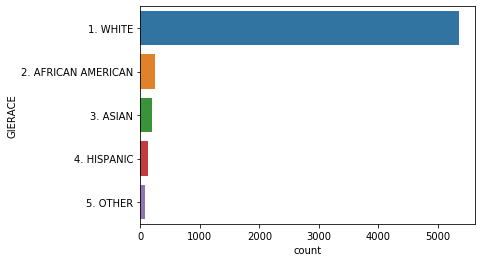

In [12]:
sns.countplot(data=form_gi_df.sort_values("GIERACE"),y="GIERACE")

This data set is predominantly white with only small representation from other ethnic groups

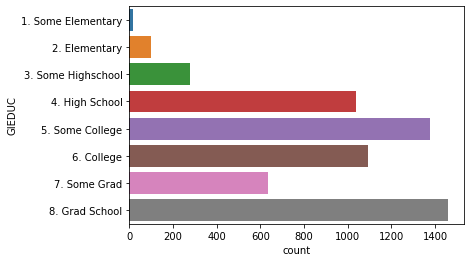

In [13]:
sns.countplot(data=form_gi_df.sort_values("GIEDUC"),y="GIEDUC")

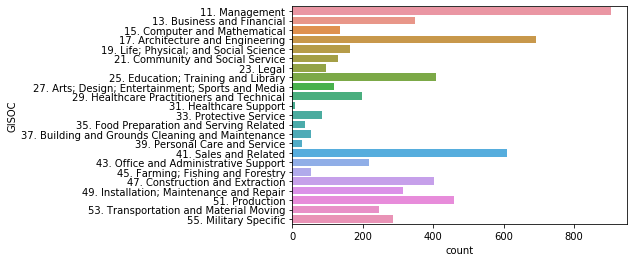

In [14]:
sns.countplot(data=form_gi_df.sort_values("GISOC"), y="GISOC")

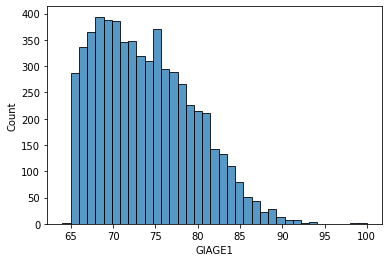

In [15]:
sns.histplot(data=form_gi_df, x="GIAGE1")

<a name="eda_bivariate"></a><h3> Bivariate Statistics and Visualizations </h3>
Below is a bivariate analysis used to determine the relationship between the incidence of fracture and our values in form GI.

In [16]:
mergedData = form_gi_df.merge(fafeb23_df,on="ID",how="inner")

In [17]:
mergedData = mergedData.dropna()

#### Education Vs Fracture.


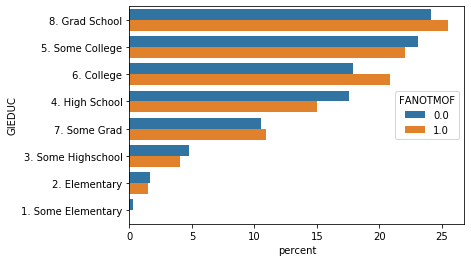

In [18]:
plot_data = mergedData.groupby("FANOTMOF")["GIEDUC"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
sns.barplot(data=plot_data,x="percent",y="GIEDUC", hue="FANOTMOF")

##### Contingency Tables

In [19]:
pd.crosstab(mergedData.FANOTMOF,mergedData.GIEDUC)

GIEDUC,1. Some Elementary,2. Elementary,3. Some Highschool,4. High School,5. Some College,6. College,7. Some Grad,8. Grad School
FANOTMOF,,,,,,,,
0.0,17,86,250,924,1214,939,551,1268
1.0,0,10,27,100,147,139,73,170


In [20]:
pd.crosstab(mergedData.FANOTMOF,mergedData.GIEDUC,normalize="index")

GIEDUC,1. Some Elementary,2. Elementary,3. Some Highschool,4. High School,5. Some College,6. College,7. Some Grad,8. Grad School
FANOTMOF,,,,,,,,
0.0,0.003239,0.016384,0.047628,0.176034,0.231282,0.178891,0.104972,0.241570
1.0,0.000000,0.015015,0.040541,0.150150,0.220721,0.208709,0.109610,0.255255


##### Chi-Squared Test of Independence

In [21]:
contingency = pd.crosstab(mergedData[~mergedData.GIEDUC.isin(["1. Some Elementary"])].FANOTMOF,mergedData[~mergedData.GIEDUC.isin(["1. Some Elementary"])].GIEDUC)
res = chi2_contingency(contingency)

In [22]:
## Expected values
pd.DataFrame(res[3])

,0,1,2,3,4,5,6
0,85.159715,245.721261,908.370295,1207.316378,956.272635,553.538149,1275.621567
1,10.840285,31.278739,115.629705,153.683622,121.727365,70.461851,162.378433


In [23]:
chi2Results(res)

The p-value is: 0.3483289303295525
The test statistic is: 6.711748646581272
Thus we cannot reject the null hypthesis and the two variables are independent


#### Race Vs Fracture.


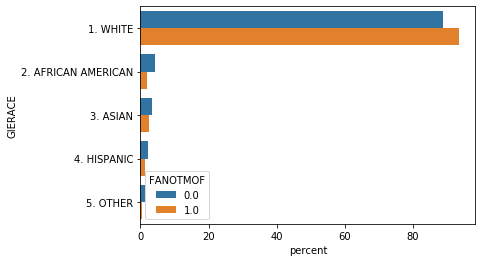

In [24]:
plot_data = mergedData.groupby("FANOTMOF")["GIERACE"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
sns.barplot(data=plot_data,x="percent",y="GIERACE", hue="FANOTMOF")

##### Contingency Tables

In [25]:
pd.crosstab(mergedData.FANOTMOF, mergedData.GIERACE)

GIERACE,1. WHITE,2. AFRICAN AMERICAN,3. ASIAN,4. HISPANIC,5. OTHER
FANOTMOF,,,,,
0.0,4664,230,172,116,67
1.0,624,13,17,9,3


In [26]:
pd.crosstab(mergedData.FANOTMOF, mergedData.GIERACE,normalize="index")

GIERACE,1. WHITE,2. AFRICAN AMERICAN,3. ASIAN,4. HISPANIC,5. OTHER
FANOTMOF,,,,,
0.0,0.888550,0.043818,0.032768,0.022099,0.012764
1.0,0.936937,0.019520,0.025526,0.013514,0.004505


##### Chi-Squared Test of Independence

In [27]:
contingency = pd.crosstab(mergedData.FANOTMOF, mergedData.GIERACE)
res= chi2_contingency(contingency)

In [28]:
pd.DataFrame(res[3])

,0,1,2,3,4
0,4692.597126,215.639391,167.719527,110.925613,62.118343
1,595.402874,27.360609,21.280473,14.074387,7.881657


In [29]:
chi2Results(res)

The p-value is: 0.002437647672064372
The test statistic is: 16.48059131213598
Thus we must reject the null hypothesis and conclude the two variables are not independent


#### Occupation Vs Fracture.


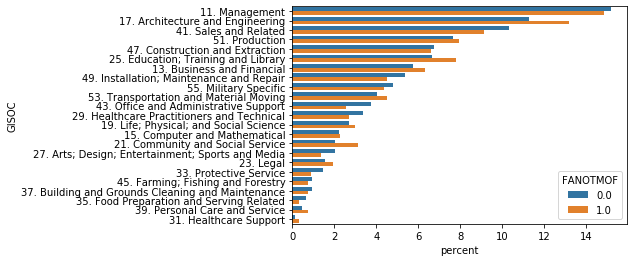

In [30]:
plot_data = mergedData.groupby("FANOTMOF")["GISOC"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
sns.barplot(data=plot_data,x="percent",y="GISOC", hue="FANOTMOF")

##### Contingency Tables

In [31]:
pd.crosstab(mergedData.FANOTMOF, mergedData.GISOC).T

FANOTMOF,0.0,1.0
GISOC,,
11. Management,798,99
13. Business and Financial,302,42
15. Computer and Mathematical,116,15
17. Architecture and Engineering,592,88
19. Life; Physical; and Social Science,141,20
21. Community and Social Service,106,21
23. Legal,82,13
25. Education; Training and Library,350,52
27. Arts; Design; Entertainment; Sports and Media,106,9


In [32]:
pd.crosstab(mergedData.FANOTMOF, mergedData.GISOC,normalize="index").T

FANOTMOF,0.0,1.0
GISOC,,
11. Management,0.152029,0.148649
13. Business and Financial,0.057535,0.063063
15. Computer and Mathematical,0.022099,0.022523
17. Architecture and Engineering,0.112783,0.132132
19. Life; Physical; and Social Science,0.026862,0.030030
21. Community and Social Service,0.020194,0.031532
23. Legal,0.015622,0.019520
25. Education; Training and Library,0.066679,0.078078
27. Arts; Design; Entertainment; Sports and Media,0.020194,0.013514


##### Chi-Squared Test of Independence

In [33]:
low_expected = ["31. Healthcare Support","35. Food Preparation and Serving Related","39. Personal Care and Service"]

In [34]:
contingency = pd.crosstab(mergedData[~mergedData.GISOC.isin(low_expected)].FANOTMOF, mergedData[~mergedData.GISOC.isin(low_expected)].GISOC)
res= chi2_contingency(contingency)

In [35]:
pd.DataFrame(res[3]).T

,0,1
0,796.104777,100.895223
1,305.306626,38.693374
2,116.265023,14.734977
3,603.513097,76.486903
4,142.890601,18.109399
5,112.714946,14.285054
6,84.314330,10.685670
7,356.782743,45.217257
8,102.064715,12.935285
9,173.066256,21.933744


In [36]:
chi2Results(res)

The p-value is: 0.6444395310856577
The test statistic is: 16.191881229433008
Thus we cannot reject the null hypthesis and the two variables are independent


#### Age

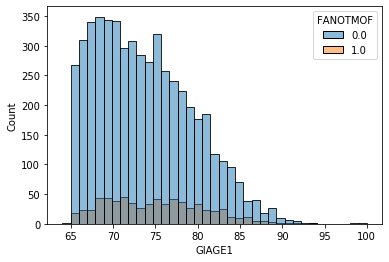

In [37]:
sns.histplot(mergedData,x="GIAGE1",hue="FANOTMOF")

### <a name="eda_FR"></a>Results for Modeling

While there is important information in form GI related to social determinants of health, The variables are not convincing that they would provide adequate information to our model. Additionally, some variables like race/ethnicity have some influence on the outcome variable, but these groups are not adequately represented. However, we will include the results and use feature reduction techniques to weed them out if necessary. Additionally, the information could potentially provide good demographic data for our data story. 


In [42]:
form_gi_final.to_csv("/dsa/groups/casestudy2023su/team03/model_data/gi_results.csv",index=False)
##os.chmod("/dsa/groups/casestudy2023su/team03/model_data/gi_results.csv",0o777)

file_path_with_nulls = "/dsa/groups/casestudy2023su/team03/model_data/null_included/GI_results_with_nulls.csv"
gi_with_nulls.to_csv(file_path_with_nulls, index=False)
##os.chmod(file_path_with_nulls, 0o777)